In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 1. MNIST

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

import deeptrack as dt

import datasets
#Download dataset from the cloud
datasets.load("MNIST")

PATH_TO_DATASET = os.path.abspath("./datasets/MNIST")

TRAINING_SET_PATH = os.path.join(PATH_TO_DATASET, "training_set.npy")
TRAINING_LABELS_PATH = os.path.join(PATH_TO_DATASET, "training_labels.npy")
VALIDATION_SET_PATH = os.path.join(PATH_TO_DATASET, "validation_set.npy")
VALIDATION_LABELS_PATH = os.path.join(PATH_TO_DATASET, "validation_labels.npy")


MNIST already downloaded! Use force_overwrite=True to redownload the dataset.


## 2. Defining the dataset

### 2.1 Loading the data

The dataset is how we provide the network with training data. For this example we create the dataset by loading it from storage using `LoadImage`.

In [3]:
# Load the images from storage
get_training_images = dt.LoadImage(path=TRAINING_SET_PATH)
get_training_labels = dt.LoadImage(path=TRAINING_LABELS_PATH)

get_validation_images = dt.LoadImage(path=VALIDATION_SET_PATH)
get_validation_labels = dt.LoadImage(path=VALIDATION_LABELS_PATH)

Note that we don't load the images yet, we have just created the objects that will do so. First we normalize the data.

In [4]:
normalization = dt.NormalizeMinMax(0, 1)

get_training_images += normalization
get_validation_images += normalization

Since all training data is contained in a single file, we explicitly load the images

In [5]:
training_images = get_training_images.resolve()
training_labels = get_training_labels.resolve()

validation_images = get_validation_images.resolve()
validation_labels = get_validation_labels.resolve()

We want to continuously generate new data for the network to train on. For this, we use the Dataset feature.

In [6]:
training_data_iterator = itertools.cycle(training_images)
training_label_iterator = itertools.cycle(training_labels)

training_iterator = dt.Dataset(
    data=training_data_iterator, 
    label=training_label_iterator
)

### 2.2 Augmenting the training set

In order to expand the dataset we augment it. 

Affine augmentations consist of translating, rescaling, rotating and shearing

In [7]:
# How much to scale in x and y
scale = {
    "x": lambda: 0.8 + np.random.rand() * 0.4,
    "y": lambda: 0.8 + np.random.rand() * 0.4
}

# How much to translate in x and y
translate_px = {
    "x": lambda: int(np.random.randint(-2, 3)),
    "y": lambda: int(np.random.randint(-2, 3))
}

# Dummy property: whether to rotate or shear
should_rotate= lambda: np.random.randint(2)

# If should rotate, how much
rotate = lambda should_rotate: (-20 + np.random.rand() * 40) * should_rotate

# If not should rotate, how much shear
shear = lambda should_rotate: (-20 + np.random.rand() * 40) * (1 - should_rotate)

affine_transform = dt.Affine(
    scale=scale,
    translate_px=translate_px,
    should_rotate=should_rotate,
    shear=shear,   
    order=2
)

We also distort the images elastically.

In [8]:
elastic_transform = dt.ElasticTransformation(
    alpha=lambda: np.random.rand() * 40, # Amplitude of distortions
    sigma=lambda: 5 + np.random.rand() * 2, # Granularity of distortions
)

Finally, since these distortions may cause pixels to fall outside the range of (0, 1), we clip the values.

In [9]:
clip = dt.Clip(0, 1)

We add the augmentations to the pipeline

In [10]:
augmented_training_set = training_iterator + elastic_transform + affine_transform + clip

### 2.3 Defining the target
The training iterator resolves images. We can extract the label that we provided to the Dataset feature by just calling `get_property`.

In [11]:
def get_label(image):
    return image.get_property("label")

### 2.3 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.

Showing images of the digit 5


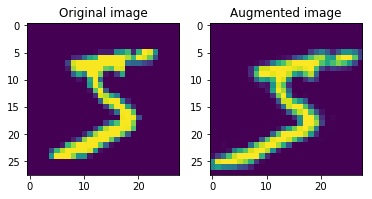

Showing images of the digit 0


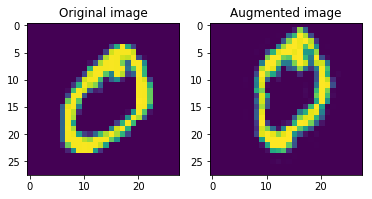

Showing images of the digit 4


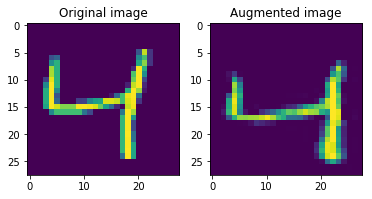

Showing images of the digit 1


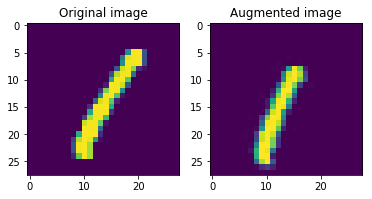

Showing images of the digit 9


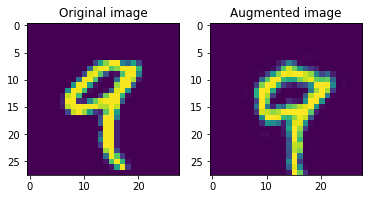

Showing images of the digit 2


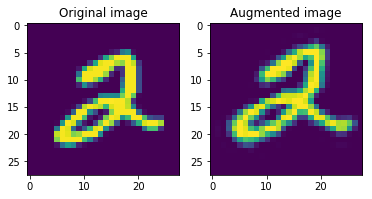

Showing images of the digit 1


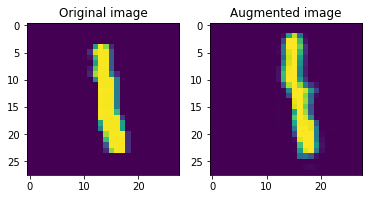

Showing images of the digit 3


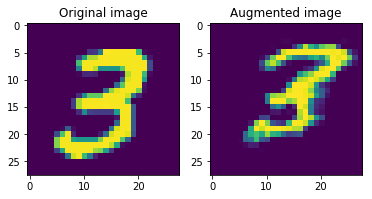

Showing images of the digit 1


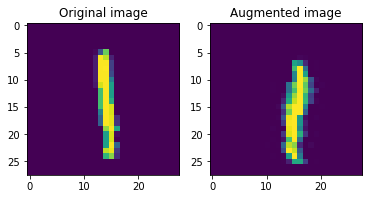

Showing images of the digit 4


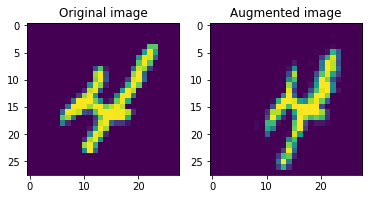

Showing images of the digit 3


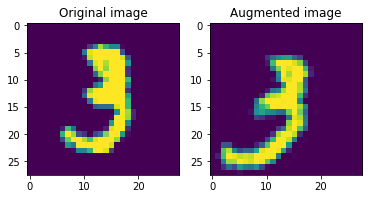

Showing images of the digit 5


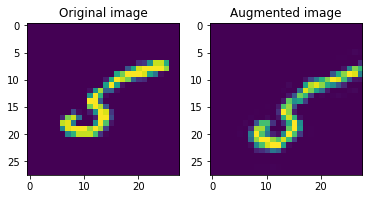

Showing images of the digit 3


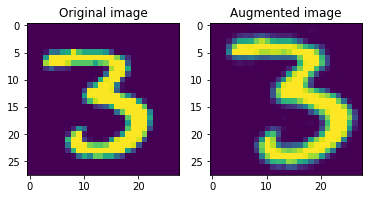

Showing images of the digit 6


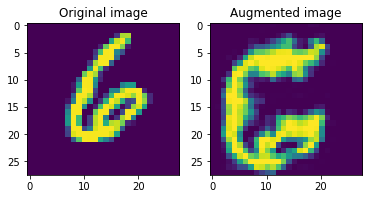

Showing images of the digit 1


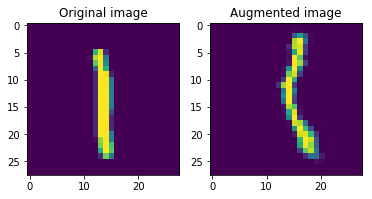

Showing images of the digit 7


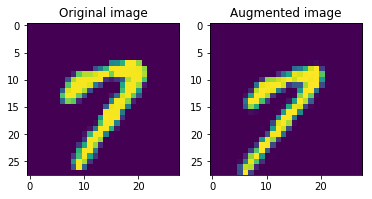

Showing images of the digit 2


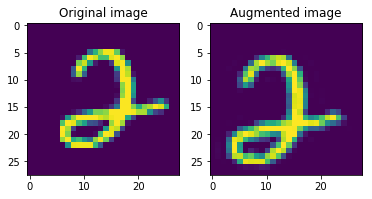

Showing images of the digit 8


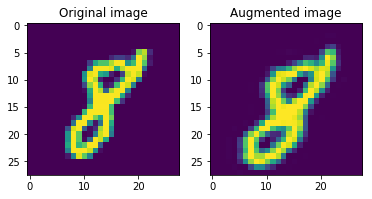

Showing images of the digit 6


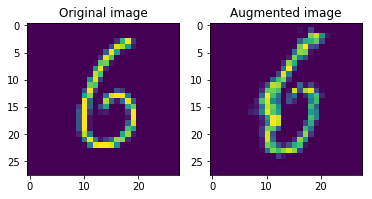

Showing images of the digit 9


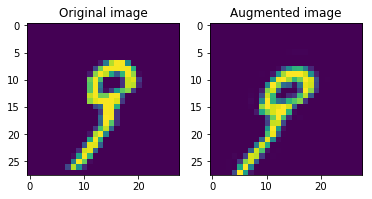

Showing images of the digit 4


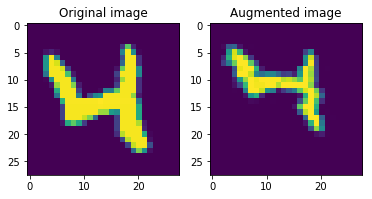

Showing images of the digit 0


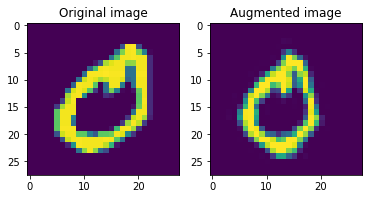

Showing images of the digit 9


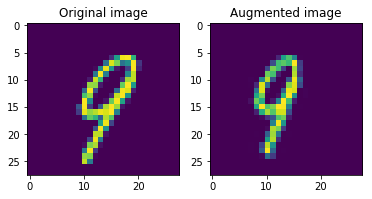

Showing images of the digit 1


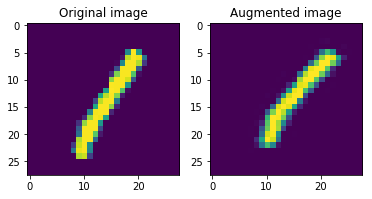

Showing images of the digit 1


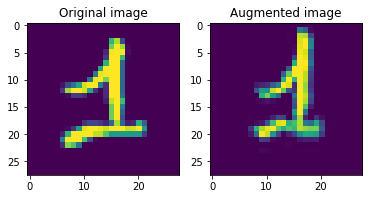

Showing images of the digit 2


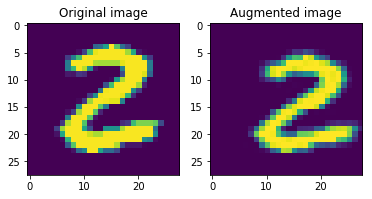

Showing images of the digit 4


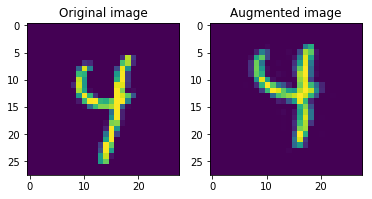

Showing images of the digit 3


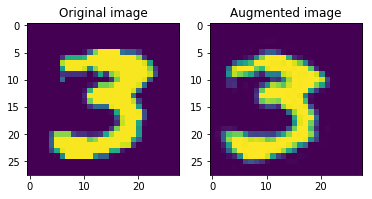

Showing images of the digit 2


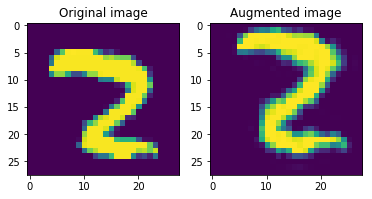

Showing images of the digit 7


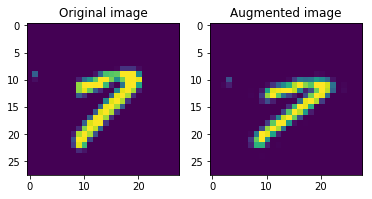

Showing images of the digit 3


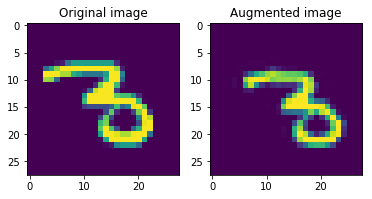

Showing images of the digit 8


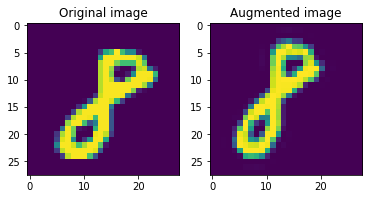

In [12]:
NUMBER_OF_IMAGES = 32

for image_index in range(NUMBER_OF_IMAGES):
    
    augmented_training_set.update()
    
    original_image = training_iterator.resolve()
    augmented_image = augmented_training_set.resolve()
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Augmented image")
    
    print("Showing images of the digit " + str(get_label(original_image)))
    plt.show()

## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.

In [13]:
model = dt.models.FullyConnected(
    input_shape=(28, 28),
    dense_layers_dimensions=(2000, 1500, 1000, 500),
    number_of_outputs=10,
    dropout=(0.25, 0.25),
    output_activation="softmax",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer="rmsprop"
)

## 4. Training the network

The network is trained for 100 epochs using standard Keras syntax.

In [14]:
TRAIN_MODEL = False

if TRAIN_MODEL:
    generator = dt.generators.Generator().generate(
        augmented_training_set,
        get_label,
        batch_size=64,
    )

    h = model.fit(
        generator,
        validation_data=(validation_images,
                         validation_labels),
        steps_per_epoch=100,
        epochs=100
    )
    
    plt.plot(h.history["loss"], 'g')
    plt.plot(h.history["val_loss"], 'r')
    plt.legend(["Loss", "Validation loss"])
    plt.yscale("log")
    plt.show()
    
else:
    import keras
    model_path = datasets.load_model("MNIST")
    model.load_weights(model_path)

MNIST already downloaded! Use force_overwrite=True to redownload the model.


## 5. Evaluating the training


In [15]:
array_of_images = validation_images
array_of_labels = validation_labels

predicted_digits = np.argmax(model.predict(array_of_images), axis=1)

accuracy = np.mean(np.array(array_of_labels) == predicted_digits)
print("Accuracy:", accuracy)
print("Error rate:",1 - accuracy)

Accuracy: 0.9921
Error rate: 0.007900000000000018


### 5.1 Prediction vs actual

We show a few images, the true digit and the predicted digit

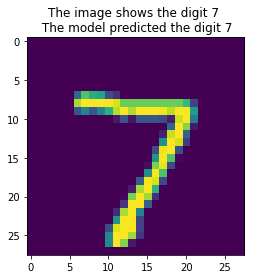

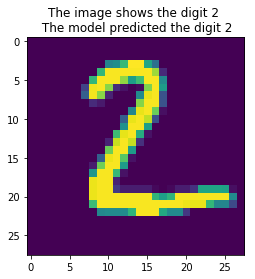

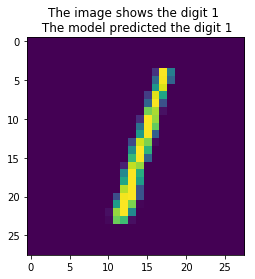

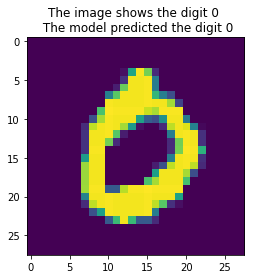

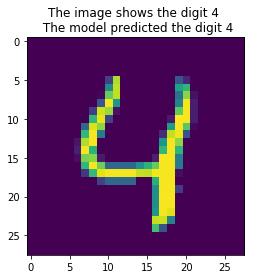

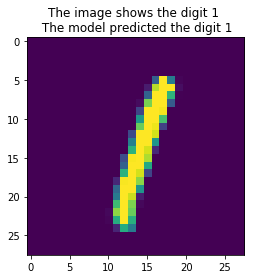

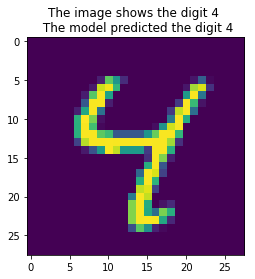

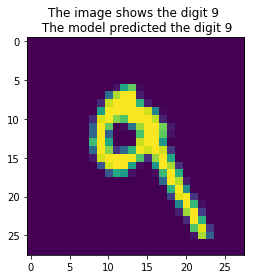

In [16]:
NUMBER_OF_IMAGES = 8 
TITLE_STRING = "The image shows the digit {0} \n The model predicted the digit {1}"

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_labels[image_index], predicted_digits[image_index]))
    plt.show()

### 5.2 Visualizing errors

We show a few images which the model predicted inaccurately

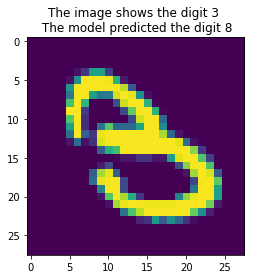

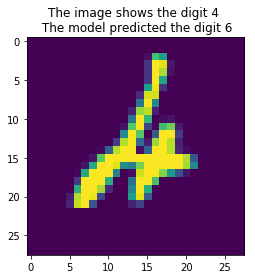

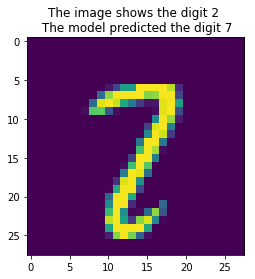

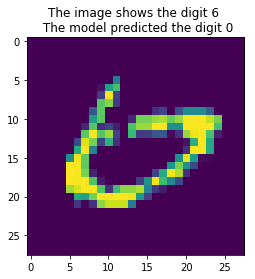

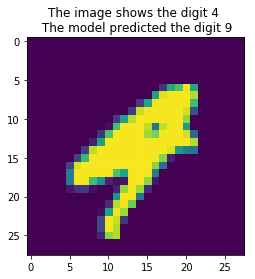

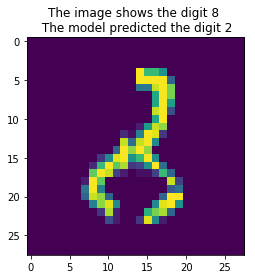

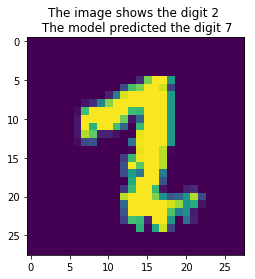

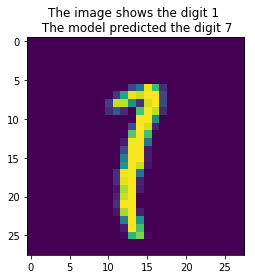

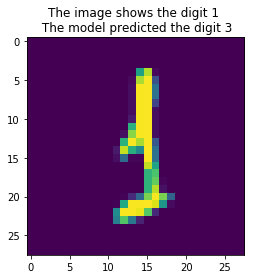

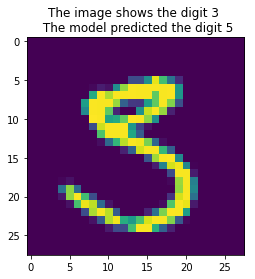

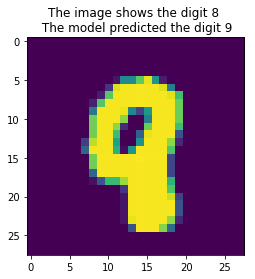

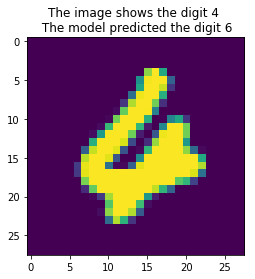

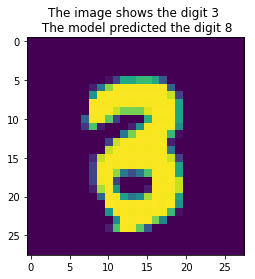

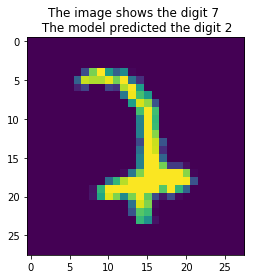

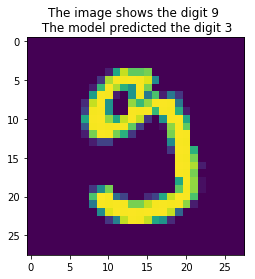

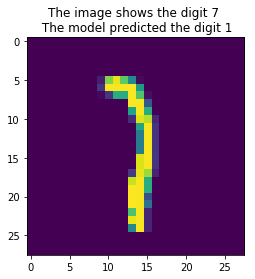

In [17]:
NUMBER_OF_IMAGES = 16

model_is_wrong = predicted_digits != array_of_labels

array_of_hard_images = array_of_images[model_is_wrong]
array_of_hard_labels = array_of_labels[model_is_wrong]
inaccurately_predicted_digits = predicted_digits[model_is_wrong]

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_hard_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_hard_labels[image_index], inaccurately_predicted_digits[image_index]))
    plt.show()